In [1]:
# | code-summary: code -- load dependencies and data and select parameters


from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import events_metadata, simulate_df
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR"]#, "compmemlearn.models.Instance_CMR"]

model_names = ["Prototype CMR"]#, "InstanceCMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    # [
    #     "encoding_drift_rate",
    #     "start_drift_rate",
    #     "recall_drift_rate",
    #     "shared_support",
    #     "item_support",
    #     "learning_rate",
    #     "primacy_scale",
    #     "primacy_decay",
    #     "stop_probability_scale",
    #     "stop_probability_growth",
    #     #    'choice_sensitivity',
    #     "context_sensitivity",
    #     #    'feature_sensitivity'
    #     "delay_drift_rate",
    # ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    # [
    #     [lb, ub],
    #     [lb, ub],
    #     [lb, ub],
    #     [lb, ub],
    #     [lb, ub],
    #     [lb, ub],
    #     [lb, 100],
    #     [lb, 100],
    #     [lb, ub],
    #     [lb, 10],
    #     [lb, 10],
    #     [lb, ub],
    # ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
#     {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
#          'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_lag_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 1000


In [2]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations, trial_details = events_metadata(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
        events,
        trial_query,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')

26220.97911668192
78143.68433758253
dependencies and parameters validated


In [3]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(trial_details.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_query = f'subject == {subject}'
            if trial_query:
                subject_specific_trial_query = trial_query + ' & ' + subject_specific_trial_query

            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                trials, list_lengths, presentations = events_metadata(events, subject_specific_trial_query)[:3]
                cost_function = generate_objective_function(
                    events,
                    subject_specific_trial_query,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': len(trials), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

Prototype CMR, Subject 1
691.1456044688886
Prototype CMR, Subject 2
412.62036998612626
Prototype CMR, Subject 3
689.3500484941551
Prototype CMR, Subject 4
280.51170498519406
Prototype CMR, Subject 5
666.587736417457
Prototype CMR, Subject 6
636.3138848263296
Prototype CMR, Subject 7
321.9102466378282
Prototype CMR, Subject 8
598.2575014044866
Prototype CMR, Subject 10
467.92811655187484
Prototype CMR, Subject 11
842.3707699694198
Prototype CMR, Subject 12
683.8238366214288
Prototype CMR, Subject 13
757.4879810128641
Prototype CMR, Subject 14
890.5856736598266
Prototype CMR, Subject 15
477.28339396649153
Prototype CMR, Subject 16
575.8413436764179
Prototype CMR, Subject 17
542.5220574056618
Prototype CMR, Subject 18
554.0673245556885
Prototype CMR, Subject 19
529.2641097487921
Prototype CMR, Subject 20
367.13124986097546
Prototype CMR, Subject 21
557.4752606923333
Prototype CMR, Subject 22
378.2707897104356
Prototype CMR, Subject 23
355.2462099537958
Prototype CMR, Subject 24
414.198254

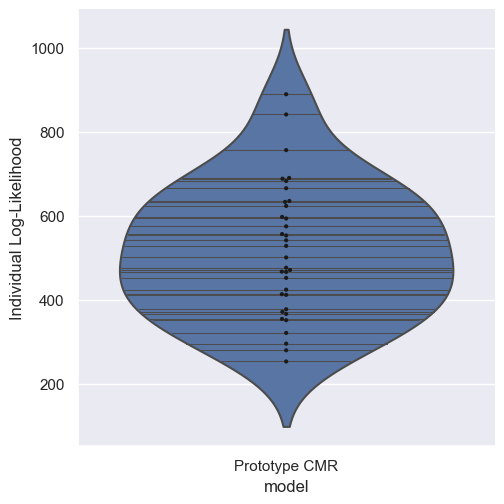

In [4]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [5]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-LohnasCondition1fits layout-nrow=2 layout-valign="center"}

![](results/individual_LohnasCondition1.pdf)

|       |   Prototype CMR |
|:------|----------------:|
| count |          35     |
| mean  |         518.185 |
| std   |         157.511 |
| min   |         253.911 |
| 25%   |         395.446 |
| 50%   |         501.683 |
| 75%   |         629.258 |
| max   |         890.586 |

Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model.
:::


In [6]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

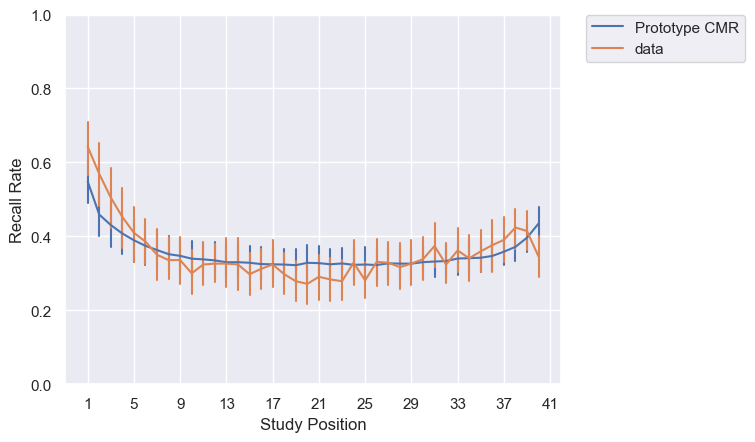

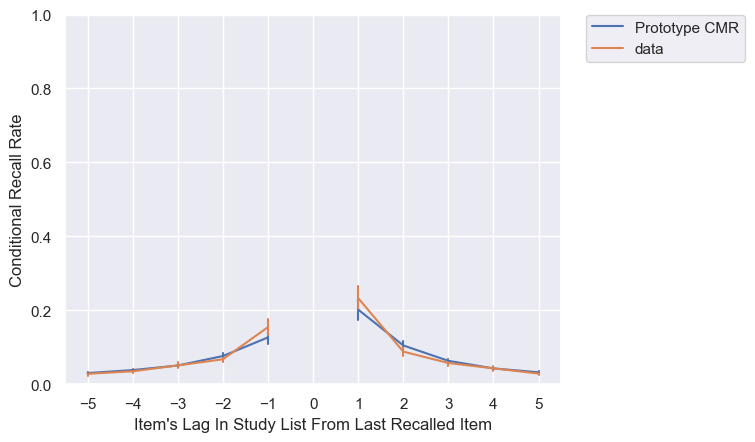

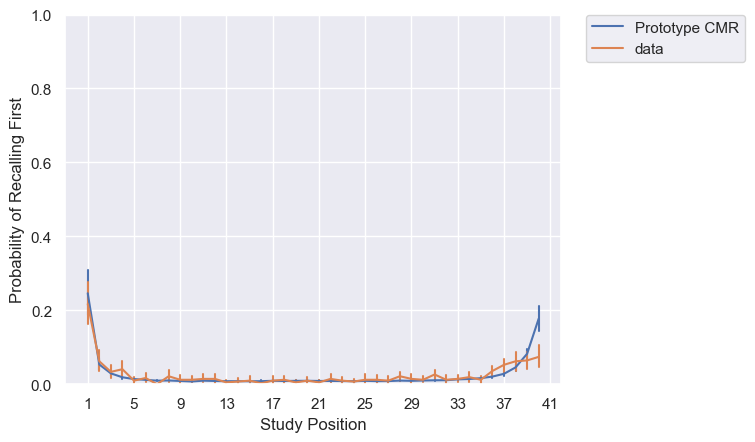

In [7]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # obtain parallel true_df structure
        if len(list_lengths) > 1:
            true_df = events.query(trial_query).query(f'`list length` == {list_length}')
        else:
            true_df = events.query(trial_query)

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function([true_df, sim_df], list_length, contrast_name="source", labels=[model_names[model_index], "data"])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")